In [1]:
import numpy as np
import SimPEG.Utils as Utils
from SimPEG.EM import TDEM
from SimPEG import Mesh, Maps
import discretize
import pickle 
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
from pymatsolver import Pardiso
import math
import matplotlib.pyplot as plt
import ipywidgets

# Set a nice colormap! 
plt.set_cmap(plt.get_cmap('viridis'))



In [2]:
def diffusion_distance(sigma, time):
    return 1.28*np.sqrt(time/(sigma * mu_0))

sigma_air = 1e-8
sigma_near_surface = 1/3
sigma_basement = 1/100
thickness_near_surface = 50.

srcLocation = np.r_[0,0,0.5]
rxLocation = np.r_[0,0,0.5]


dbdt_sensor_delay = 2e-5
b_sensor_delay = 3e-5
ramp_off_time = 20e-6
source_current = 20
source_diameter = 50.
radius = math.sqrt(source_diameter**2/math.pi)
max_x = 200.
max_z = 250.
times = np.arange(0.0001,0.1,0.0001)+ramp_off_time

print(
    'min diffusion distance: {:.2f} m'.format(diffusion_distance(max(sigma_near_surface,sigma_basement), times.min()))
)
print(
    'max diffusion distance: {:6.2f} m'.format(diffusion_distance(min(sigma_near_surface,sigma_basement), times.max()))
)

csx = 2
ncsx = max_x/csx
npadx = 17

csz = 2
ncsz = np.ceil(max_z/csz)
npadz = 17

pf = 1.7

hx = Utils.meshTensor([(csx,ncsx),(csx,npadx,pf)])
hz = Utils.meshTensor([(csz,npadz,-pf),(csz,ncsz),(csz,npadz,pf)])
mesh = Mesh.CylMesh([hx,1,hz],x0=np.r_[0,0,-hz.sum()/2. - max_z/2. + 5])
print('max grid dimensions: {:6.2f}m, {:6.2f}m'.format(max(mesh.gridCC[:,0]),max(mesh.gridCC[:,2]),mesh.nC))



min diffusion distance: 21.66 m
max diffusion distance: 3609.37 m
max grid dimensions: 32102.98m, 31907.98m


Text(0.5, 1.0, 'Simulation Mesh')

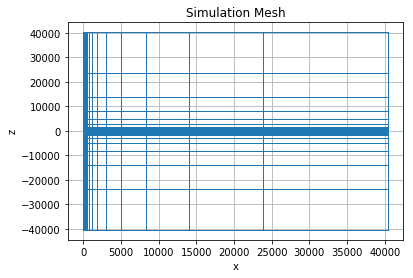

In [3]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')



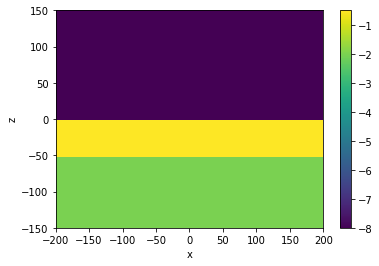

In [4]:
sigma = np.ones(mesh.nC) * sigma_air
sigma[mesh.gridCC[:,2] < 0. ] = sigma_near_surface
sigma[mesh.gridCC[:,2]< -thickness_near_surface] = sigma_basement

xlim = np.r_[-200., 200]
zlim = np.r_[-150, 150]
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plotImage(np.log10(sigma),mirror=True,ax=ax)[0])
ax.set_xlim(xlim)
ax.set_ylim(zlim)
plt.show()



In [5]:
dbdt_z = TDEM.Rx.Point_dbdt(locs=rxLocation, times=times, orientation='z')  # vertical db_dt
rxLocationOffset = np.copy(rxLocation)
rxLocation[0] =  0.5*source_diameter
dbdt_z_offset = TDEM.Rx.Point_dbdt(locs=rxLocationOffset, times=times,orientation='z')
rxList = [dbdt_z,dbdt_z_offset]

timeSteps = [(1e-06, 10), (5e-06, 10), (1e-05, 10), (5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 10),(5e-3, 10),(1e-2,4)] 

wave = TDEM.Src.RampOffWaveform(offTime=ramp_off_time)

source = TDEM.Src.CircularLoop(rxList = rxList, loc=srcLocation, radius=source_diameter/2., current=source_current, waveform=wave)
survey = TDEM.Survey([source])
sigmaMap = Maps.IdentityMap(mesh)
problem = TDEM.Problem3D_b(mesh, sigmaMap=sigmaMap, timeSteps=timeSteps, Solver=Pardiso)
problem.pair(survey)
print(
    'The maximum time is {:1.1e}. \n There are {} timesteps, '
    '{} of them distinct (which is the same as the number of matrices that need to be factored)'.format(
        problem.times[-1], problem.nT, (len(timeSteps))
    )
)



The maximum time is 1.1e-01. 
 There are 84 timesteps, 9 of them distinct (which is the same as the number of matrices that need to be factored)


In [6]:
fields = problem.fields(sigma)

In [8]:
x = np.unique(mesh.gridCC[:,0])
y = np.unique(mesh.gridCC[:,2])
nx = len(x)
ny = len(y)
mx, my = np.meshgrid(x,y)

def plot(i):
    v = np.zeros(survey.nD)
    v[i+len(dbdt_z.times)] = 1.
    jt = problem.Jtvec(sigma,v,f=fields)

    fig, ax = plt.subplots(1,2,figsize=(15,15))
    values = jt.reshape((ny,nx))
    minColourBar = values.max()*0.01
    maxColourBar = values.max()
    ax[0].set_aspect('equal')
    pcm = ax[0].pcolormesh(mx,my,abs(values),vmin=minColourBar,vmax=maxColourBar)

    ax[0].set_title(('Center Receiver Sensitivty %5.2f ms')%((dbdt_z.times[i]- ramp_off_time)*1e3))
    ax[0].set_xlim([0,200])
    ax[0].set_ylim([-200,0])
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Radius (m)')
    fig.colorbar(pcm,ax=ax[0],fraction=0.046, pad=0.04)
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[0].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[0].plot(x,y,'b-')

    v = np.zeros(survey.nD)
    v[i] = 1.
    jt = problem.Jtvec(sigma,v,f=fields)

    values = jt.reshape((ny,nx))
    ax[1].set_aspect('equal')
    pco = ax[1].pcolormesh(mx,my,abs(values),vmin=minColourBar,vmax=maxColourBar)
    ax[1].set_title(('25m Offset Receiver Sensitivity at %5.2f ms')%((dbdt_z.times[i]- ramp_off_time)*1e3))
    ax[1].set_xlim([0,200])
    ax[1].set_ylim([-200,0])
    fig.colorbar(pco,ax=ax[1],fraction=0.046, pad=0.04)
    x = np.linspace(-400,400,100)
    y = np.zeros(len(x))
    ax[1].plot(x,y,'b-')
    y = np.ones(len(x))*-thickness_near_surface
    ax[1].plot(x,y,'b-')
    ax[1].set_ylabel('Depth (m)')
    ax[1].set_xlabel('Radius (m)')
    
    return ax

ipywidgets.interact(
    plot, 
    i=ipywidgets.IntSlider(min=1, max=50, value=10) 
)

interactive(children=(IntSlider(value=10, description='i', max=50, min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot(i)>